In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from ridnet import RIDNET
from dncnn import DnCNN
from evaluate import evaluate_model
from visualize import get_patches,create_image_from_patches,predict_fun,plot_patches,plot_predictions,psnr_np


In [5]:
#Get data filepaths
train_files=['dataset/patches/train/'+filename for filename in os.listdir('dataset/patches/train')]
test_files=['dataset/patches/test/'+filename for filename in os.listdir('dataset/patches/test')]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 64

NUM_EPOCHS = 30
# Create a dataloader class for pytorch to ingest data into model
class CustomDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image_decoded = Image.open(file_path).convert('RGB')
        image = transforms.ToTensor()(image_decoded)
        # add random noise in patches
        noise_level = np.random.choice([20,30,40])
        noise = torch.randn(image.size()) * noise_level / 255.
        noisy_image = torch.clamp(image + noise, 0., 1.)
        return noisy_image, image

# Create dataset instances
train_dataset = CustomDataset(train_files)
test_dataset = CustomDataset(test_files)

# Create DataLoader instances for batching
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
test_img_path = 'dataset/test/0791.jpg'
loaded_model = DnCNN()  # Example: ResNet-18
# Define the file path to the saved checkpoint
checkpoint_path = './dncnn.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state_dict
loaded_model.load_state_dict(checkpoint)
loaded_model.to("cuda")
# Set the model to evaluation mode
loaded_model.eval()
print("PSNR and SSIM for test data : ",evaluate_model(loaded_model, test_data_loader))
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image_1=predict_fun(loaded_model,test_img_path,noise_level=40)
print('DNCNN PSNR of Noisy Image : ',psnr_np(ground_truth,noisy_image))
dncnn_psnr = psnr_np(ground_truth,denoised_image_1)
print("DNCNN psnr",dncnn_psnr)
# plot_predictions(ground_truth,noisy_image,denoised_image_1)

PSNR and SSIM for test data :  (26.947121727829643, 0.9984977906216171)
(100, 40, 40, 3) (400, 400, 3)
DNCNN PSNR of Noisy Image :  16.94417949608118
DNCNN psnr 26.06737932347817


In [42]:
loaded_model = RIDNET()  # Example: ResNet-18
# Define the file path to the saved checkpoint
checkpoint_path = './ridnet.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Load the model state_dict
loaded_model.load_state_dict(checkpoint)
loaded_model.to("cuda")
# Set the model to evaluation mode
loaded_model.eval()
print("PSNR and SSIM for test data : ",evaluate_model(loaded_model, test_data_loader))
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(loaded_model,test_img_path,noise_level=40)
print('RIDNET PSNR of Noisy Image : ',psnr_np(ground_truth,noisy_image))
ridnet_psnr = psnr_np(ground_truth,denoised_image)
print("RIDNET PSNR : ",ridnet_psnr)
# plot_predictions(ground_truth,noisy_image,denoised_image)

PSNR and SSIM for test data :  (29.071520902061142, 0.9999307594792564)
(100, 40, 40, 3) (400, 400, 3)
RIDNET PSNR of Noisy Image :  16.921815943054675
RIDNET PSNR :  27.470461036179927


In [43]:
ground_truth.shape

(400, 400, 3)

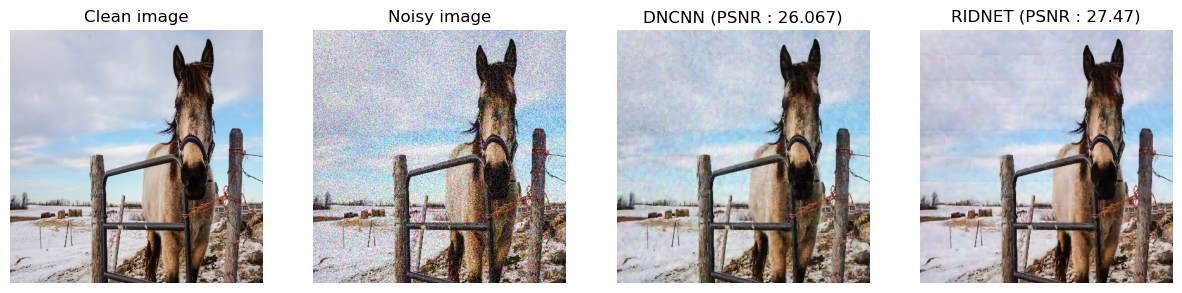

In [44]:
import matplotlib.pyplot as plt

def plot_images(img0,img1, img2, img3):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(img0)
    axes[0].set_title('Clean image')
    axes[0].axis('off')
    axes[1].imshow(img1)
    axes[1].set_title('Noisy image')
    axes[1].axis('off')
    axes[2].imshow(img2)
    axes[2].set_title(f"DNCNN (PSNR : {np.round(dncnn_psnr,3)})")
    axes[2].axis('off')
    axes[3].imshow(img3)
    axes[3].set_title(f"RIDNET (PSNR : {np.round(ridnet_psnr,3)})")
    axes[3].axis('off')
    plt.show()

# Example usage:
plot_images(ground_truth,noisy_image, denoised_image_1, denoised_image)
